<a href="https://colab.research.google.com/github/lucguittard/DS-Unit-2-Applied-Modeling/blob/master/DSproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Authorizing access to G-Drive

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Making a new df

### Reading-In and Initial Edits 

In [0]:
path = "/content/drive/My Drive/dsProject2/household-debt/household-debt-by-county.csv"
df = pd.read_csv(path)                         #2013-2017
path2 = "/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/Income.csv" 
df2 = pd.read_csv(path2, encoding='latin-1')   #2018-2019
path = '/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/County Classifications.csv'
df3 = pd.read_csv(path, encoding='latin-1')    #2013-2015
path4 = '/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/Veterans.csv'
df4 = pd.read_csv('/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/Veterans.csv', encoding='latin-1') #2018-2019
path5 = '/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/People.csv'      #2010-2019
df5 = pd.read_csv(path5, encoding='latin-1')
path6 = '/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/Jobs.csv'        #2018-2019
df6 = pd.read_csv(path6, encoding='latin-1') 
path9 = '/content/drive/My Drive/dsProject2/2015CountyTypologyCodes.csv'          #2013-2015
df9 = pd.read_csv(path9, encoding='latin-1')
path10 = '/content/drive/My Drive/dsProject2/creativeclass200711.csv'             #2007-2011
df10 = pd.read_csv(path10, encoding='latin-1')

In [0]:
df = df.rename(columns = {"area_fips": "FIPS"})
mask = (df['year'] > 2012)
df = df[mask]

df2 = df2.drop(0)

df3 = df3.rename(columns = {'FIPStxt': 'FIPS'})
df3 = df3[['FIPS','RuralUrbanContinuumCode2013','Low_Education_2015_update','Low_Employment_2015_update',
           'Population_loss_2015_update', 'Metro_Adjacent2013']]

df4 = df4.drop(0)
df4 = df4[['FIPS','Vets18OPct','MaleVetsPct','PctVetsPoor','PctNonVetsPoor','PctVetsDisabilty','PctNonVetsDisabilty']]

df5 = df5.drop(0)
df5 = df5[['FIPS','PopChangeRate1018','NetMigrationRate1018','PopDensity2010','Under18Pct2010','Age65AndOlderPct2010','ForeignBornPct']]

df6 = df6.drop(0)
df6 = df6[['FIPS','UnempRate2018','UnempRate2015','PctEmpChange1018','PctEmpAgriculture','PctEmpMining','PctEmpConstruction','PctEmpManufacturing',
          'PctEmpTrade','PctEmpTrans','PctEmpInformation','PctEmpFIRE','PctEmpServices','PctEmpGovt']]

df9 = df9.rename(columns = {'FIPStxt': 'FIPS'})
df9 = df9[['FIPS','Metro-nonmetro status, 2013 0=Nonmetro 1=Metro','Persistent_Poverty_2013',
           'Persistent_Related_Child_Poverty_2013','Economic_Type_Label','Economic Types Type_2015_Update non-overlapping']]

df10 = df10[['FIPS','CCShare','CCShareSE','BohShare','BohShareSE','CCShareRME','BohShareRME','metro03']]

### Merging County-lvl. Data

In [0]:
merge1 = pd.merge(df,df2, on='FIPS')
merge2 = pd.merge(merge1,df3,on='FIPS')
merge3 = pd.merge(merge2,df4, on = 'FIPS')
merge4 = pd.merge(merge3,df5, on = 'FIPS')
merge5 = pd.merge(merge4,df6, on = 'FIPS')
merge6 = pd.merge(merge5,df9, on = 'FIPS')
merge7 = pd.merge(merge6,df10, on = 'FIPS')

merge7.to_csv('/content/drive/My Drive/dsProject2/merge7.csv', index = False)
merge7.shape

NameError: ignored

## Work on full dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
dfv = pd.read_csv('/content/drive/My Drive/dsProject2/merge7.csv')
dfv = dfv.drop(columns = ['State', 'County'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (51,52,53,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
dfv.head()

### extra: Open Baseline  (not for use)
Want to predict debt rates (here, the low-end estimate) - much data missing for high-end

In [3]:
dfv['low'] = pd.cut(dfv['low'],5,labels = False) #specify 2 class. for binary set -> use w/ ROC-AUC
dfv['low'].value_counts(normalize=True) 
#baseline (majority class) = 0.404 
# classes are imbalanced -> tryout ROC, class_weight param (scikit learn), oversamp techniques

1    0.404341
2    0.210263
3    0.201532
0    0.094023
4    0.089841
Name: low, dtype: float64

### Split + Data Wrangling


In [3]:
dfv.year.value_counts()

2014    12532
2013    12532
2015    12531
2017    12530
2016    12530
Name: year, dtype: int64

In [9]:
print(dfv.high.isna().sum())
dfv.describe() #search for outliers)

5629


,year,qtr,FIPS,low,high,MedHHInc,PerCapitaInc,PovertyUnder18Pct,PovertyAllAgesPct,Deep_Pov_All,Deep_Pov_Children,PovertyUnder18Num,PovertyAllAgesNum,RuralUrbanContinuumCode2013,Type_2015_Update,Low_Education_2015_update,Low_Employment_2015_update,Population_loss_2015_update,Metro_Adjacent2013,Vets18OPct,MaleVetsPct,PctVetsPoor,PctNonVetsPoor,PctVetsDisabilty,PctNonVetsDisabilty,PopChangeRate1018,NetMigrationRate1018,PopDensity2010,Under18Pct2010,Age65AndOlderPct2010,ForeignBornPct,UnempRate2018,UnempRate2015,PctEmpChange1018,PctEmpAgriculture,PctEmpMining,PctEmpConstruction,PctEmpManufacturing,PctEmpTrade,PctEmpTrans,PctEmpInformation,PctEmpFIRE,PctEmpServices,PctEmpGovt,"Metro-nonmetro status, 2013 0=Nonmetro 1=Metro",Persistent_Poverty_2013,Persistent_Related_Child_Poverty_2013,Economic Types Type_2015_Update non-overlapping,metro03
count,62655.000000,62655.000000,62655.000000,62655.000000,57026.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,6.265500e+04,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62635.000000,62633.000000,62655.000000,62633.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000
mean,2014.999904,2.499912,30434.477903,1.589594,1.784266,51090.927859,26028.989466,21.539181,15.369999,6.837130,9.862390,4260.963642,1.358945e+04,4.999745,1.803224,0.149070,0.288501,0.168191,0.325529,9.131256,93.251904,10.292955,15.725721,21.710711,13.069458,0.912304,-0.068713,259.875793,23.424248,15.889234,4.699224,4.117328,5.081973,4.143761,5.109760,1.657380,7.236874,12.314099,13.740817,5.499841,1.401149,4.567650,42.877837,5.594593,0.371878,0.112042,0.225345,1.803224,0.347618
std,1.414225,1.118036,15122.689325,0.904544,0.795370,13499.325639,6245.052428,9.104896,6.248520,3.365953,6.053082,15299.468105,4.717956e+04,2.704962,1.816347,0.356161,0.453069,0.374039,0.468576,2.653430,3.515534,7.026248,6.499362,9.748714,4.581544,7.488828,6.475147,1726.633879,3.315113,4.176274,5.700756,1.453532,2.008620,11.297478,6.355135,3.543960,2.313199,7.191012,2.678393,2.042336,0.844417,1.881224,6.959250,3.175156,0.483310,0.315421,0.417813,1.816347,0.476218
min,2013.000000,1.000000,1001.000000,0.000000,0.780000,22679.000000,10960.000000,2.700000,3.000000,0.000000,0.000000,11.000000,1.300000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,71.826625,0.000000,0.000000,0.000000,0.967742,-26.150000,-25.880000,0.040000,9.110000,3.470000,0.000000,1.300000,1.000000,-32.680000,0.000000,0.000000,0.000000,0.000000,1.156069,0.000000,0.000000,0.000000,5.128205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,1.000000,19003.000000,1.010000,1.190000,42275.000000,21805.000000,14.800000,10.900000,4.552548,5.684925,509.000000,1.636000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.550806,91.666667,5.933251,11.007071,15.504587,9.812482,-3.730000,-3.710000,17.050000,21.430000,13.130000,1.354839,3.100000,4.000000,-2.690000,1.136425,0.080877,5.659038,6.718598,12.319050,4.172427,0.880626,3.393541,38.254865,3.570954,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,2.000000,29181.000000,1.580000,1.580000,48851.000000,25267.000000,20.500000,14.400000,6.293835,8.848700,1210.000000,3.893000e+03,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.898224,93.523833,9.268293,15.003651,20.443430,12.526395,-0.400000,-1.050000,45.300000,23.330000,15.570000,2.691027,3.900000,5.000000,3.460000,2.863436,0.311268,6.964006,11.441608,13.921248,5.156076,1.318681,4.275394,42.666369,4.731340,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2016.000000,3.000000,45081.000000,2.160000,2.160000,56678.000000,29096.000000,26.700000,18.400000,8.303840,12.633262,2850.00

In [4]:
#holdout test set
test = dfv.query('year == 2017') 

# Split train into train & val
#dfv['averageDebtRate'] = (dfv['low'] + dfv['high'])

#split on time-series
re_train = dfv.query('year < 2016')
re_val = dfv.query('year == 2016') #val set approx. 25% of (post- test-split) dataset 
print(re_train.shape,re_val.shape)

#split by random
train, val = train_test_split(test, train_size=0.80, stratify=test['low'], random_state=12)
train.shape, val.shape

(37595, 56) (12530, 56)


((10024, 56), (2506, 56))

In [0]:
# import pandas_profiling as pp
# pp.ProfileReport(train)

In [0]:
def wrangle(X):    
    X = X.copy()
    target = X.low
    
    #managing outliers
    X = X.query('MedHHInc < 70000')
    X = X.query('PerCapitaInc < 45000')
    X = X.query('PovertyUnder18Pct < 40')
    X = X.query('PovertyAllAgesPct < 35')
    X = X.query('Deep_Pov_All < 18')
    
    
    #feat/engineering
    X = X.drop(columns=['high']) #column of (many) nan
    X = X.query('qtr == 4')
    
    # Drop duplicate columns --> none yet
    duplicates = []
    X = X.drop(columns=duplicates)
    
    # Drop unusable variances
    unusable_variance = ['FIPS','year','qtr']
    X = X.drop(columns=unusable_variance)
    
    #bin the y-continuous feat
    X['debt_class'] = pd.cut(X['low'],5,labels = False) #labels = False -> bins are indicated by integer values
    
    # return the wrangled dataframe
    return X
  
def wrangle2(X):
    least_feats = list_feats[35:]
    X = X.copy()
    X = X.query('qtr == 4')
    X = X.drop(columns = least_feats)
    X = X.drop(columns = ['FIPS','high','year','qtr'])
    return X
  
train = wrangle(train)
val = wrangle(val)
re_train = wrangle(re_train)
re_val = wrangle(re_val)
test = wrangle(test)

In [0]:
# The status_group column is the target
target = 'debt_class'

train_features = train.drop(columns=[target])
re_train_features = re_train.drop(columns = [target])

# list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
re_numeric_features = re_train_features.select_dtypes(include='number').columns.tolist()

# # series with cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
re_cardinality = re_train_features.select_dtypes(exclude='number').nunique()

# list of categorical features w/cardinality <= 25Pct
categorical_features = cardinality[cardinality <= 50].index.tolist() #none w/wrangle2 function; all w/cards in 1000s
re_categorical_features = re_cardinality[re_cardinality <= 10].index.tolist()

# combine lists 
features = numeric_features + categorical_features
re_features = re_numeric_features + categorical_features

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

re_X_train = re_train[re_features]
re_y_train = re_train[target]
re_X_val = re_val[re_features]
re_y_val = re_val[target]

### Exploratory visuals

In [15]:
dfv.head()

,year,qtr,FIPS,low,high,MedHHInc,PerCapitaInc,PovertyUnder18Pct,PovertyAllAgesPct,Deep_Pov_All,Deep_Pov_Children,PovertyUnder18Num,PovertyAllAgesNum,RuralUrbanContinuumCode2013,Type_2015_Update,Low_Education_2015_update,Low_Employment_2015_update,Population_loss_2015_update,Metro_Adjacent2013,Vets18OPct,MaleVetsPct,PctVetsPoor,PctNonVetsPoor,PctVetsDisabilty,PctNonVetsDisabilty,PopChangeRate1018,NetMigrationRate1018,PopDensity2010,Under18Pct2010,Age65AndOlderPct2010,ForeignBornPct,UnempRate2018,UnempRate2015,PctEmpChange1018,PctEmpAgriculture,PctEmpMining,PctEmpConstruction,PctEmpManufacturing,PctEmpTrade,PctEmpTrans,PctEmpInformation,PctEmpFIRE,PctEmpServices,PctEmpGovt,"Metro-nonmetro status, 2013 0=Nonmetro 1=Metro",Persistent_Poverty_2013,Persistent_Related_Child_Poverty_2013,Economic_Type_Label,Economic Types Type_2015_Update non-overlapping,CCShare,CCShareSE,BohShare,BohShareSE,CCShareRME,BohShareRME,metro03
0,2013,1,1001,3.46,NaN,58343.0,27824.0,19.3,13.4,5.85432,9.668756,2542.0,7390.0,2.0,0.0,0.0,0.0,0.0,0.0,12.562753,89.544132,3.43461,13.985967,18.626156,15.676579,1.55,0.28,91.8,26.78,12.0,2.113162,3.6,5.0,6.76,0.605508,0.315196,5.134373,13.321168,12.881553,7.436131,1.671367,5.573988,41.908593,11.152123,1,0,0,Nonspecialized,0,0.23529,0.01264,0.0058,0.00168,0.02079,0.00277,1
1,2013,2,1001,3.46,NaN,58343.0,27824.0,19.3,13.4,5.85432,9.668756,2542.0,7390.0,2.0,0.0,0.0,0.0,0.0,0.0,12.562753,89.544132,3.43461,13.985967,18.626156,15.676579,1.55,0.28,91.8,26.78,12.0,2.113162,3.6,5.0,6.76,0.605508,0.315196,5.134373,13.321168,12.881553,7.436131,1.671367,5.573988,41.908593,11.152123,1,0,0,Nonspecialized,0,0.23529,0.01264,0.0058,0.00168,0.02079,0.00277,1
2,2013,3,1001,3.46,NaN,58343.0,27824.0,19.3,13.4,5.85432,9.668756,2542.0,7390.0,2.0,0.0,0.0,0.0,0.0,0.0,12.562753,89.544132,3.43461,13.985967,18.626156,15.676579,1.55,0.28,91.8,26.78,12.0,2.113162,3.6,5.0,6.76,0.605508,0.315196,5.134373,13.321168,12.881553,7.436131,1.671367,5.573988,41.908593,11.152123,1,0,0,Nonspecialized,0,0.23529,0.01264,0.0058,0.00168,0.02079,0.00277,1
3,2013,4,1001,3.46,NaN,58343.0,27824.0,19.3,13.4,5.85432,9.668756,2542.0,7390.0,2.0,0.0,0.0,0.0,0.0,0.0,12.562753,89.544132,3.43461,13.985967,18.626156,15.676579,1.55,0.28,91.8,26.78,12.0,2.113162,3.6,5.0,6.76,0.605508,0.315196,5.134373,13.321168,12.881553,7.436131,1.671367,5.573988,41.908593,11.152123,1,0,0,Nonspecialized,0,0.23529,0.01264,0.0058,0.00168,0.02079,0.00277,1
4,2014,1,1001,3.46,NaN,58343.0,27824.0,19.3,13.4,5.85432,9.668756,2542.0,7390.0,2.0,0.0,0.0,0.0,0.0,0.0,12.562753,89.544132,3.43461,13.985967,18.626156,15.676579,1.55,0.28,91.8,26.78,12.0,2.113162,3.6,5.0,6.76,0.605508,0.315196,5.134373,13.321168,12.881553,7.436131,1.671367,5.573988,41.908593,11.152123,1,0,0,Nonspecialized,0,0.23529,0.01264,0.0058,0.00168,0.02079,0.00277,1


In [8]:
import plotly.express as px

px.scatter(train, x='low',y='PctEmpConstruction', color = 'debt_class', opacity = .2)

#consider q-cut method of binning

### Split Baseline + Dist Plot + Confusion Matrix

In [19]:
#baseline
import numpy as np
from sklearn.metrics import accuracy_score

y_train.value_counts(normalize=True)  #baseline = .415 (for class 1 of 5)

1    0.419278
2    0.216581
3    0.188814
0    0.102737
4    0.072590
Name: debt_class, dtype: float64

In [20]:
#dist plot
import plotly.figure_factory as ff

hist_data = [y_val]
group_labels = ['low debt rates groupings'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

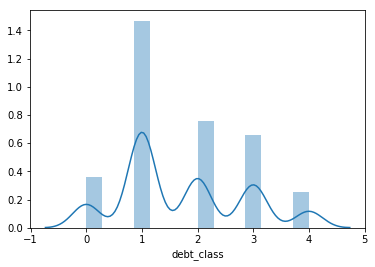

In [11]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

In [0]:
#Accuracy score for baseline
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred) 

0.7201986754966887

In [0]:
#confusion matrix for majority class baseline
#from sklearn.metrics import confusion_matrix
y_pred = pipeline.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[ 70, 261,  86,  17,   1],
       [  0,   1,  24,  82,  62],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]])

In [0]:
#precision and recall for model/majority class baseline
from sklearn.metrics import classification_report #confusion matrix used for multi-class. types
print(classification_report(y_val, y_pred)) 

              precision    recall  f1-score   support

           0       1.00      0.16      0.28       435
           1       0.00      0.01      0.00       169
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.12       604
   macro avg       0.20      0.03      0.06       604
weighted avg       0.72      0.12      0.20       604



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### PDP Plots

In [8]:
!pip install category_encoders
import category_encoders as ce
from sklearn.metrics import r2_score
from xgboost import XGBRegressor, XGBClassifier
from sklearn.pipeline import make_pipeline

In [43]:
#begin with a fit model
gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.999999999205096


In [44]:
!pip install pdpbox

from pdpbox.pdp import pdp_isolate, pdp_plot

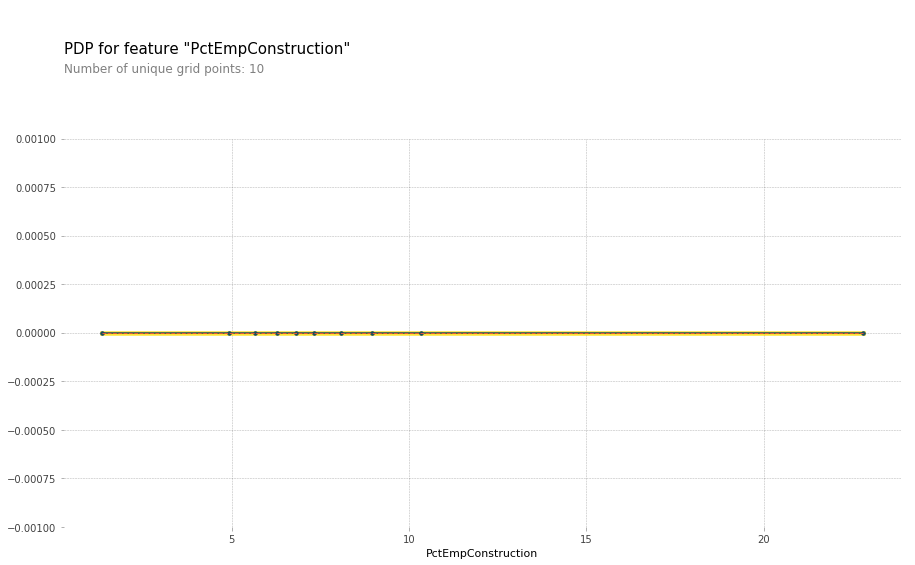

In [56]:
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact_plot

feature = 'PctEmpConstruction'
isolated = pdp_isolate(model = gb, dataset = X_val, model_features = X_val.columns,
                       feature =feature)

plt.rcParams['figure.dpi'] = 72
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);

#need to assume a class/cat approach

In [42]:
#PDP of Categorical feats
from sklearn.ensemble import RandomForestClassifier


#drop non-cats

#define target and feats

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train)

model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model.fit(X_encoded, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

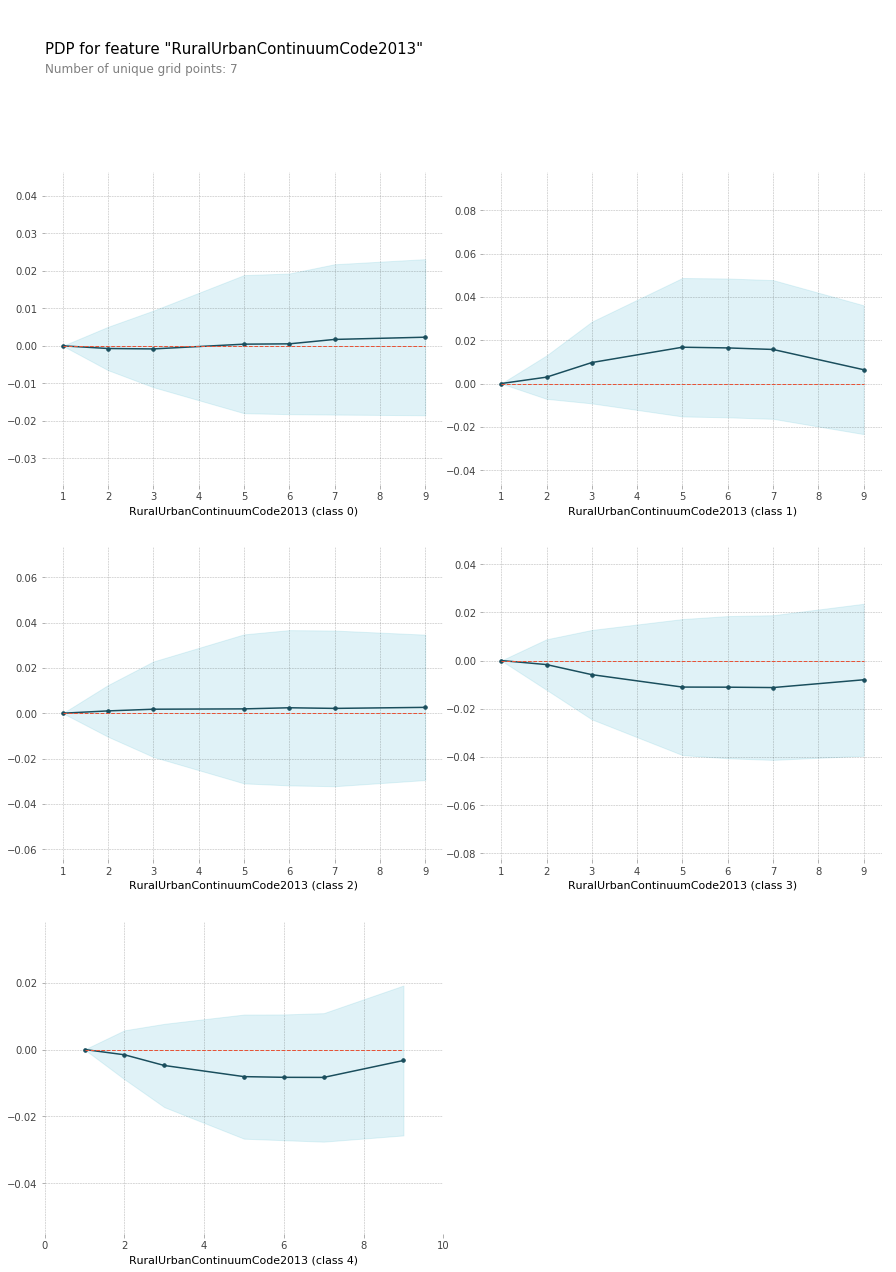

In [58]:
#Then plot via Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'RuralUrbanContinuumCode2013'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features= X_train.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature)
plt.xlim(0,10);

In [35]:
train.head()

,low,MedHHInc,PerCapitaInc,PovertyUnder18Pct,PovertyAllAgesPct,Deep_Pov_All,Deep_Pov_Children,PovertyUnder18Num,PovertyAllAgesNum,RuralUrbanContinuumCode2013,Type_2015_Update,Low_Education_2015_update,Low_Employment_2015_update,Population_loss_2015_update,Metro_Adjacent2013,Vets18OPct,MaleVetsPct,PctVetsPoor,PctNonVetsPoor,PctVetsDisabilty,PctNonVetsDisabilty,PopChangeRate1018,NetMigrationRate1018,PopDensity2010,Under18Pct2010,Age65AndOlderPct2010,ForeignBornPct,UnempRate2018,UnempRate2015,PctEmpChange1018,PctEmpAgriculture,PctEmpMining,PctEmpConstruction,PctEmpManufacturing,PctEmpTrade,PctEmpTrans,PctEmpInformation,PctEmpFIRE,PctEmpServices,PctEmpGovt,"Metro-nonmetro status, 2013 0=Nonmetro 1=Metro",Persistent_Poverty_2013,Persistent_Related_Child_Poverty_2013,Economic_Type_Label,Economic Types Type_2015_Update non-overlapping,CCShare,CCShareSE,BohShare,BohShareSE,CCShareRME,BohShareRME,metro03,debt_class
24192,0.00,46762.0,28488.0,31.8,22.1,11.325533,18.014184,39518.0,130267.0,1.0,4.0,0.0,0.0,1.0,0.0,6.012918,89.931358,19.186740,20.117272,22.567374,13.449273,-2.98,-5.85,7671.52,21.51,11.73,7.996986,5.7,7.0,4.17,0.180965,0.029501,4.422314,4.494629,10.882016,5.693748,1.940249,5.631507,58.318283,8.406787,1,1,1,Federal/State Government,4,0.23453,0.00404,0.011842,0.00076,0.00664,0.00125,1,0
55154,1.01,40353.0,21938.0,22.9,16.4,6.301327,7.211210,645.0,2031.0,6.0,4.0,1.0,0.0,1.0,1.0,9.295097,91.693635,1.782820,16.666667,41.653160,16.396243,-5.11,-5.72,13.94,25.62,15.57,4.239901,4.1,4.0,-15.40,4.771686,2.559646,3.839469,13.414441,11.423606,3.744667,0.616211,6.051509,48.380471,5.198294,0,0,0,Federal/State Government,4,0.15893,0.01979,0.008036,0.00705,0.03255,0.0116,0,1
1659,0.78,53877.0,20952.0,28.8,23.2,10.161324,11.746805,970.0,2248.0,7.0,0.0,0.0,1.0,0.0,0.0,7.196262,88.311688,21.071429,23.974164,17.142857,9.384498,4.86,-7.19,0.41,34.33,6.35,2.148141,11.6,11.0,1.14,1.099203,3.132729,3.352569,3.544930,8.189063,9.123386,0.522121,2.170926,51.250343,17.614729,0,0,0,Nonspecialized,0,0.18421,0.02519,0.00554,0.00252,0.04144,0.00415,0,1
53232,1.19,41434.0,21093.0,28.7,19.1,10.387480,18.324508,1513.0,4192.0,6.0,4.0,0.0,1.0,0.0,1.0,7.495713,95.350554,4.093567,18.825360,27.095517,13.403345,0.12,-1.25,25.83,23.59,16.13,9.450596,4.7,5.0,-12.55,3.955122,5.768359,7.026292,10.675431,12.092022,6.085675,0.487307,2.765186,43.857661,7.286945,0,0,1,Federal/State Government,4,0.14044,0.01163,0.005464,0.00324,0.01913,0.00534,0,1
31292,3.46,61592.0,26781.0,15.1,10.3,5.194633,7.838299,764.0,2315.0,1.0,0.0,0.0,0.0,0.0,0.0,9.561503,93.746278,9.189843,12.958167,20.556227,13.468331,-2.60,-2.34,41.30,24.97,14.83,0.861805,3.6,5.0,2.58,2.584662,0.452787,7.150269,17.026696,13.508160,8.489765,2.424300,3.914725,39.901896,4.546741,1,0,0,Nonspecialized,0,0.1578,0.01514,0.002801,0.0021,0.02491,0.00345,1,4


In [59]:
# can also examine encoder's mappings
encoder.mapping

#NaN always there 

[{'col': 'Economic_Type_Label',
  'data_type': dtype('O'),
  'mapping': Federal/State Government    1
  Nonspecialized              2
  Maufacturing                3
  Farming                     4
  Mining                      5
  Recreation                  6
  NaN                        -2
  dtype: int64}]

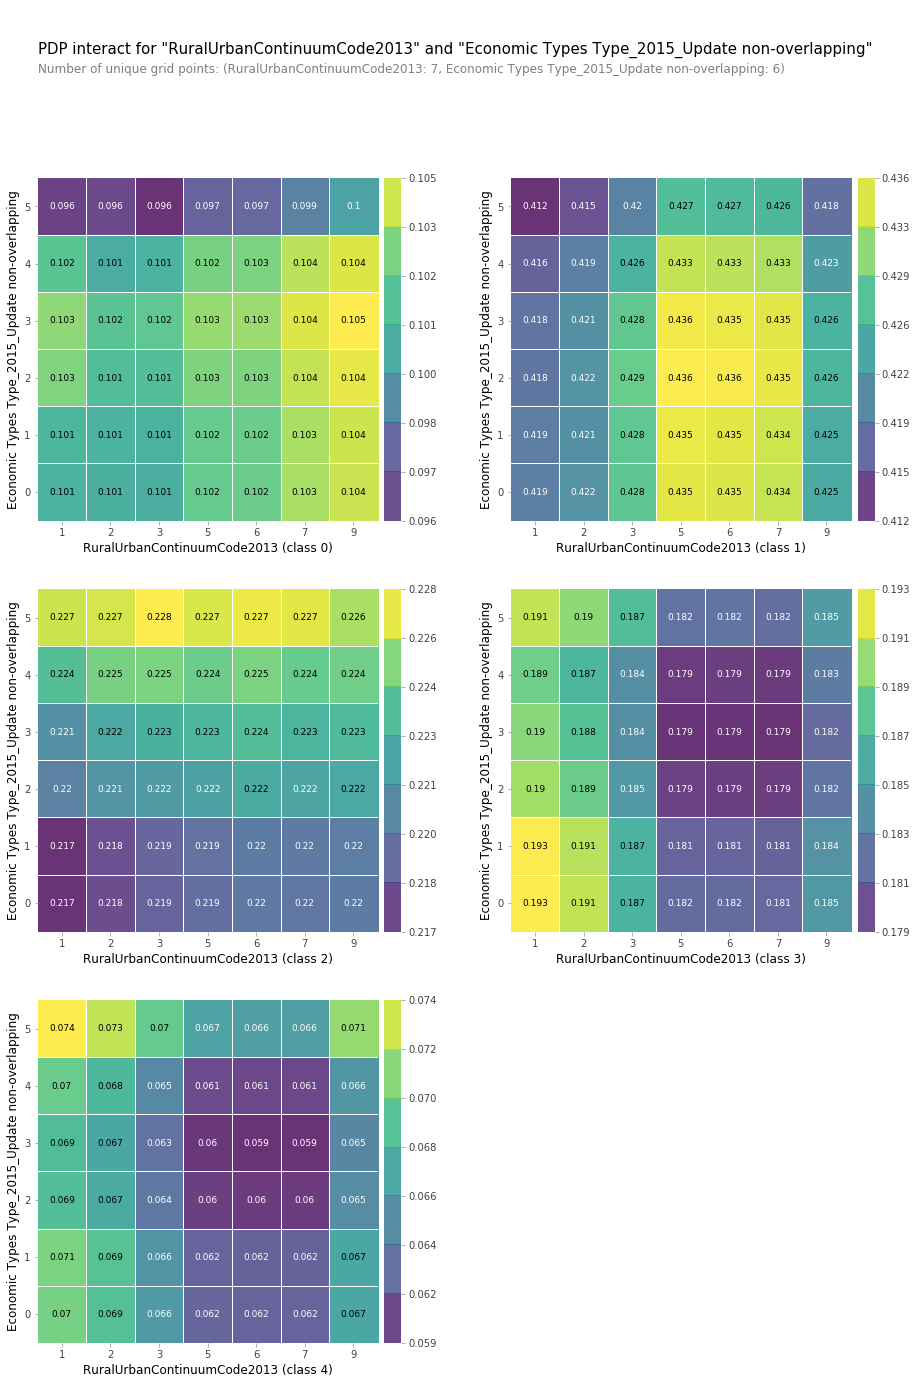

In [60]:
#Two Feat Interaction PDP table
features = ['RuralUrbanContinuumCode2013', 'Economic Types Type_2015_Update non-overlapping']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Feat Importance: Permutation 

In [21]:
#Permutation method via eli5 lib
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

# "Importance can be measured by looking at how much the score (eg. accuracy) 
#  decreases when a feature is not available."

     |████████████████████████████████| 112kB 5.0MB/s 


Using TensorFlow backend.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [23]:
# defining a model
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
    )

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model.fit(X_train_transformed, y_train)


# permutation and plot 
permuter = PermutationImportance(
    model,
    scoring='accuracy', 
    n_iter=2, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

#Interpreting: values at top are most important feats

# "The first number in each row shows how much model performance decreased with a random shuffling.
# The number after the ± measures how performance varied from one-reshuffling to the next.
# You'll occasionally see negative values for permutation importances. In those cases, 
# the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. 
# This happens when the feature didn't matter (should have had an importance close to 0), 
# but random chance caused the predictions on shuffled data to be more accurate. 
# This is more common with small datasets, like the one in this example, 
# because there is more room for luck/chance." source:
# https://www.kaggle.com/dansbecker/permutation-importance

#For Blog: sxn. perhaps important to reflect on the ordering here... why some feats may appear to be reversed

Weight,Feature
0.0165 ± 0.0331,PctEmpConstruction
0.0087 ± 0.0016,UnempRate2015
0.0063 ± 0.0000,Economic Types Type_2015_Update non-overlapping
0.0055 ± 0.0079,PctEmpGovt
0.0047 ± 0.0063,Low_Employment_2015_update
0.0047 ± 0.0063,Economic_Type_Label
0.0039 ± 0.0079,PctEmpTrans
0.0039 ± 0.0016,PctNonVetsDisabilty
0.0031 ± 0.0031,ForeignBornPct
0.0031 ± 0.0126,Population_loss_2015_update


### XG-BOOST

In [63]:
X_train.head()

,low,MedHHInc,PerCapitaInc,PovertyUnder18Pct,PovertyAllAgesPct,Deep_Pov_All,Deep_Pov_Children,PovertyUnder18Num,PovertyAllAgesNum,RuralUrbanContinuumCode2013,Type_2015_Update,Low_Education_2015_update,Low_Employment_2015_update,Population_loss_2015_update,Metro_Adjacent2013,Vets18OPct,MaleVetsPct,PctVetsPoor,PctNonVetsPoor,PctVetsDisabilty,PctNonVetsDisabilty,PopChangeRate1018,NetMigrationRate1018,PopDensity2010,Under18Pct2010,Age65AndOlderPct2010,ForeignBornPct,UnempRate2018,UnempRate2015,PctEmpChange1018,PctEmpAgriculture,PctEmpMining,PctEmpConstruction,PctEmpManufacturing,PctEmpTrade,PctEmpTrans,PctEmpInformation,PctEmpFIRE,PctEmpServices,PctEmpGovt,"Metro-nonmetro status, 2013 0=Nonmetro 1=Metro",Persistent_Poverty_2013,Persistent_Related_Child_Poverty_2013,Economic Types Type_2015_Update non-overlapping,metro03,Economic_Type_Label
24192,0.00,46762.0,28488.0,31.8,22.1,11.325533,18.014184,39518.0,130267.0,1.0,4.0,0.0,0.0,1.0,0.0,6.012918,89.931358,19.186740,20.117272,22.567374,13.449273,-2.98,-5.85,7671.52,21.51,11.73,7.996986,5.7,7.0,4.17,0.180965,0.029501,4.422314,4.494629,10.882016,5.693748,1.940249,5.631507,58.318283,8.406787,1,1,1,4,1,Federal/State Government
55154,1.01,40353.0,21938.0,22.9,16.4,6.301327,7.211210,645.0,2031.0,6.0,4.0,1.0,0.0,1.0,1.0,9.295097,91.693635,1.782820,16.666667,41.653160,16.396243,-5.11,-5.72,13.94,25.62,15.57,4.239901,4.1,4.0,-15.40,4.771686,2.559646,3.839469,13.414441,11.423606,3.744667,0.616211,6.051509,48.380471,5.198294,0,0,0,4,0,Federal/State Government
1659,0.78,53877.0,20952.0,28.8,23.2,10.161324,11.746805,970.0,2248.0,7.0,0.0,0.0,1.0,0.0,0.0,7.196262,88.311688,21.071429,23.974164,17.142857,9.384498,4.86,-7.19,0.41,34.33,6.35,2.148141,11.6,11.0,1.14,1.099203,3.132729,3.352569,3.544930,8.189063,9.123386,0.522121,2.170926,51.250343,17.614729,0,0,0,0,0,Nonspecialized
53232,1.19,41434.0,21093.0,28.7,19.1,10.387480,18.324508,1513.0,4192.0,6.0,4.0,0.0,1.0,0.0,1.0,7.495713,95.350554,4.093567,18.825360,27.095517,13.403345,0.12,-1.25,25.83,23.59,16.13,9.450596,4.7,5.0,-12.55,3.955122,5.768359,7.026292,10.675431,12.092022,6.085675,0.487307,2.765186,43.857661,7.286945,0,0,1,4,0,Federal/State Government
31292,3.46,61592.0,26781.0,15.1,10.3,5.194633,7.838299,764.0,2315.0,1.0,0.0,0.0,0.0,0.0,0.0,9.561503,93.746278,9.189843,12.958167,20.556227,13.468331,-2.60,-2.34,41.30,24.97,14.83,0.861805,3.6,5.0,2.58,2.584662,0.452787,7.150269,17.026696,13.508160,8.489765,2.424300,3.914725,39.901896,4.546741,1,0,0,0,1,Nonspecialized


In [68]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=1, n_jobs=-1)
)
X_train2 = X_train[['PctEmpConstruction','RuralUrbanContinuumCode2013']]
X_val2 = X_val[['PctEmpConstruction','RuralUrbanContinuumCode2013']]
pipeline.fit(X_train2, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='multi:softprob', random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
        

In [70]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val2)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.4485981308411215


In [71]:
#Avoiding Overfit via Early Stopping
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train2)
X_val_encoded = encoder.transform(X_val2)

X_train.shape, X_val.shape, X_train_encoded.shape, X_val_encoded.shape

((2203, 46), (535, 46), (2203, 2), (535, 2))

In [83]:
eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)] 

model = XGBClassifier(
    n_estimators=1000, # <= 1000 trees, depends on early stopping
    max_depth=8,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.1, # try higher learning rate
    n_jobs=-1
)

model.fit(X_train_encoded, y_train, eval_set=eval_set, 
          eval_metric='merror', early_stopping_rounds=17) #change after early-stop analysis -> see plot below -> b/w epochs 15&20

# classification error is reported w/each training iteration (after each boosted tree is added to the model)
# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

[0]	validation_0-merror:0.423513	validation_1-merror:0.568224
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 17 rounds.
[1]	validation_0-merror:0.412619	validation_1-merror:0.562617
[2]	validation_0-merror:0.40808	validation_1-merror:0.566355
[3]	validation_0-merror:0.397186	validation_1-merror:0.573832
[4]	validation_0-merror:0.391739	validation_1-merror:0.573832
[5]	validation_0-merror:0.394462	validation_1-merror:0.568224
[6]	validation_0-merror:0.389469	validation_1-merror:0.560748
[7]	validation_0-merror:0.378575	validation_1-merror:0.564486
[8]	validation_0-merror:0.379483	validation_1-merror:0.573832
[9]	validation_0-merror:0.374489	validation_1-merror:0.57757
[10]	validation_0-merror:0.365865	validation_1-merror:0.579439
[11]	validation_0-merror:0.364957	validation_1-merror:0.570093
[12]	validation_0-merror:0.364049	validation_1-merror:0.570093
[13]	validation_0-merror:0.362

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [84]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val2)
print('Validation Accuracy', accuracy_score(y_val, y_pred))


Validation Accuracy 0.4485981308411215


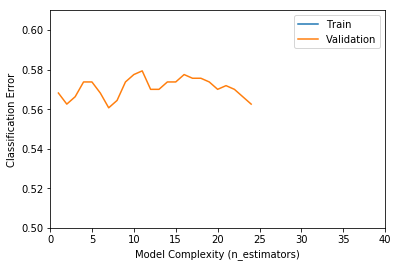

In [75]:
import matplotlib.pyplot as plt
results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.5, 0.61))  # Zoom in
plt.xlim((.05,40))
plt.legend();

#consider stop learning b/w epoch 15 and 20  

In [76]:
val_accuracy = model(X_val2,y_val)
val_accuracy

TypeError: ignored

### ROC-AUC
Alter wrangling fxn for binary class.

In [0]:
#roc & auc for majority class baseline
from sklearn.metrics import roc_auc_score  #works with binary class. types

y_pred_proba = np.full_like(y_val, fill_value=1.00)
roc_auc_score(y_val, y_pred_proba)

0.5

In [0]:
#roc/auc for model
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba) #very poor score (0.115)

0.11493572740257091

In [0]:
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    For binary classification problems. 
    y_pred_proba : predicted probability of class 1
    """
    
    # Apply threshold to predicted probabilities
    # to get discrete predictions
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    # Plot distribution of predicted probabilities
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    # Calculate true positive rate and false positive rate
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Plot point on ROC curve for the current threshold
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    # Show ROC AUC score
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))

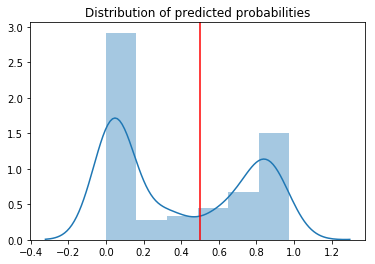

False Positive Rate 0.5908045977011495
True Positive Rate 0.005917159763313609


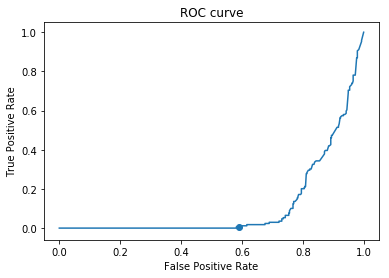

Area under the Receiver Operating Characteristic curve: 0.11493572740257091


In [0]:
set_threshold((y_val), (y_pred_proba))

### Pipeline + Model Val. Score

In [16]:
#pipeline time

!pip install category_encoders
import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1)
    )

# Fit on train, score on val

pipeline.fit(X_train,y_train)
print('Validation Accuracy (random-split, top-35 feats)', pipeline.score(X_val,y_val))

pipeline.fit(re_X_train, re_y_train)
print('Validation Accuracy (time-split, top-35 feats < Wrangle)', pipeline.score(re_X_val, re_y_val)) 

# Wrangle 1 Accuracies: r-split(.774), t-split(.829)
# Wrangle 2 Accuracies: r-split(.772),t-split(.829) 
# no meaningful difference b/w cardinality < 11 and that < 51; time-based split consistently more accurate

     |████████████████████████████████| 92kB 5.7MB/s 
Validation Accuracy (random-split, top-35 feats) 0.49133858267716535
Validation Accuracy (time-split, top-35 feats < Wrangle) 0.7777777777777778


In [0]:
# cross validation
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    )

k = 5
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy') #scoring changes w/type of model applied (cluster, class, regression)
print(f'Accuracy Score for {k} folds:', scores)

#Accuracy Score for 5 folds: [0.74448456 0.76314733 0.77550201 0.76697469 0.77099237] 

In [0]:
X_train.index
X_train.columns

Index(['Deep_Pov_Children', 'PovertyUnder18Num', 'PovertyAllAgesNum',
       'RuralUrbanContinuumCode2013', 'Type_2015_Update',
       'Low_Education_2015_update', 'Low_Employment_2015_update',
       'Population_loss_2015_update', 'Metro_Adjacent2013', 'Vets18OPct',
       'MaleVetsPct', 'PctVetsPoor', 'PctNonVetsPoor', 'PctVetsDisabilty',
       'PctNonVetsDisabilty', 'PopChangeRate1018', 'NetMigrationRate1018',
       'PopDensity2010', 'Under18Pct2010', 'Age65AndOlderPct2010',
       'ForeignBornPct', 'UnempRate2018', 'UnempRate2015', 'PctEmpChange1018',
       'PctEmpAgriculture', 'PctEmpMining', 'PctEmpConstruction',
       'PctEmpManufacturing', 'PctEmpTrade', 'PctEmpTrans',
       'PctEmpInformation', 'PctEmpFIRE', 'PctEmpServices', 'PctEmpGovt',
       'Metro-nonmetro status, 2013 0=Nonmetro 1=Metro',
       'Persistent_Poverty_2013', 'Persistent_Related_Child_Poverty_2013',
       'Economic Types Type_2015_Update non-overlapping', 'metro03',
       'MedHHInc', 'PerCapitaInc', 

### Overfit-Underfit Traversal

### Feat Importances 

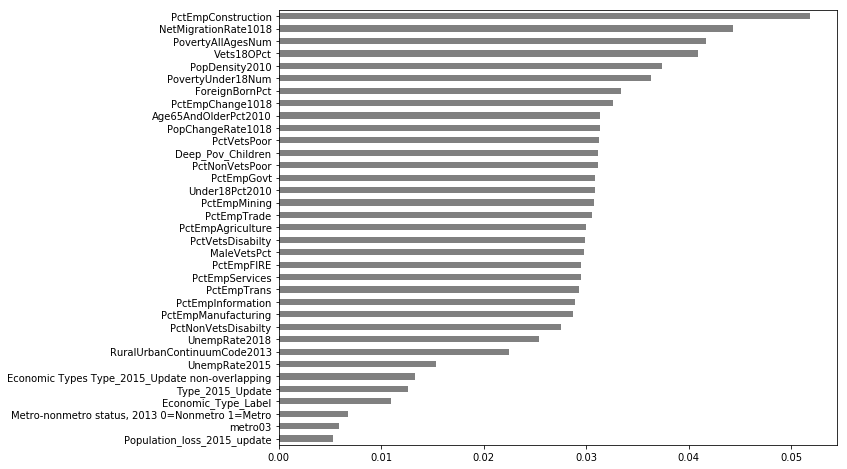

In [0]:
# feat. importances  #broken after 2nd iteration; doesn't work after passage through Wrangle2
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.nlargest(n=35).sort_values().plot.barh(color = 'grey')

In [0]:
df_importances = pd.DataFrame(importances)
df_importances = df_importances.reset_index()
df_importances = df_importances.rename(columns={0: "value", "index": "feature"})
df_importances = df_importances.sort_values(by=['value'], ascending = False)
#df_importances.head(35) 
# now fetch a list of the most important feat names
list_feats = list(df_importances.feature)

### ptPlot - PctEmpConstruction vs 'low'

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

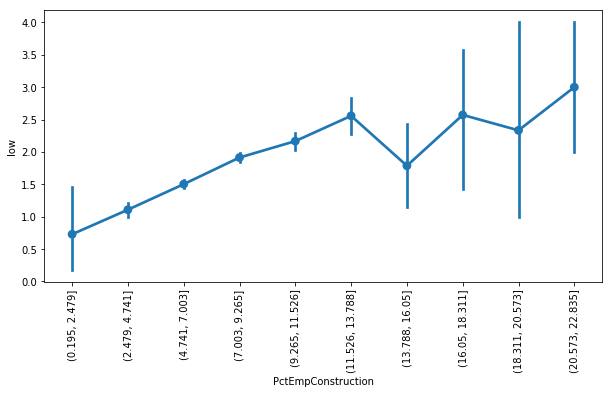

In [0]:
plt.figure(figsize = (10,5))
import seaborn as sns
sns.pointplot(x = pd.cut(train['PctEmpConstruction'],bins = 10), y = train['low'])
plt.xticks(rotation = 90) 